# import the required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np

import random 

import plotly.express as px
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.ticker as ticker
import plotly.figure_factory as ff

from fbprophet import Prophet
from pandas_datareader import data
from scipy import stats
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler

from matplotlib.ticker import FixedFormatter, FixedLocator

from scipy.sparse import csr_matrix
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score



import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install tldextract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tldextract
data = pd.read_csv("/content/drive/MyDrive/phishing_site_urls.csv")

In [ ]:
data

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad


In [ ]:
def count_digits(string):
    total_number = 0
    for char_ in list(map(str, "0123456789")):
        total_number += string.lower().count(char_)
    return total_number

def count_letter(string):
    total_letter = 0
    for char_ in list(map(str, "abcdefghijklmnopqrstuvwxyz")):
        total_letter += string.lower().count(char_)
    return total_letter 
                
    
features = ["total_digits_domain", "total_digits_path", "total_digits_url", 
               "total_letter_domain", "total_letter_path", "total_letter_url",
               "len_domain", "len_url", "len_path"]


new_data = {"len_domain": [], 
            "len_path": [],
            "len_url": [], 
            "total_digits_domain": [],
            "total_digits_path": [], 
            "total_digits_url": [],
            "total_letter_domain": [],
            "total_letter_path": [], 
            "total_letter_url": []}
#to split url:
for index, current in enumerate(data["URL"]):
    url_split = current.split("/", 1)
    if len(url_split) == 2:
        domain, path = url_split[0], url_split[1]
    else:
        domain, path = url_split[0], ""
   
    new_data["total_digits_domain"].append(count_digits(domain))
    new_data["total_digits_path"].append(count_digits(path))
    new_data["total_digits_url"].append(count_digits(current))
    
    new_data["total_letter_domain"].append(count_letter(domain))
    new_data["total_letter_path"].append(count_letter(path))
    new_data["total_letter_url"].append(count_letter(current))
    
    new_data["len_domain"].append(len(domain))
    new_data["len_path"].append(len(path))
    new_data["len_url"].append(len(current))

In [ ]:
for feature in features:
    data[feature] = new_data[feature]

In [ ]:
data

,URL,Label,total_digits_domain,total_digits_path,total_digits_url,total_letter_domain,total_letter_path,total_letter_url,len_domain,len_url,len_path
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,0,58,58,8,127,135,9,225,215
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,0,1,1,13,52,65,15,81,65
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,0,47,47,15,96,111,16,177,160
3,mail.printakid.com/www.online.americanexpress....,bad,0,0,0,16,36,52,18,60,41
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,0,21,21,18,64,82,19,116,96
...,...,...,...,...,...,...,...,...,...,...,...
549341,23.227.196.215/,bad,11,0,11,0,0,0,14,15,0
549342,apple-checker.org/,bad,0,0,0,15,0,15,17,18,0
549343,apple-iclods.org/,bad,0,0,0,14,0,14,16,17,0
549344,apple-uptoday.org/,bad,0,0,0,15,0,15,17,18,0


In [ ]:
#fun to plot hist:
def get_histplot_central_tendency(df: dict, fields: list, target: str):
    colors = sns.color_palette('cool')
    for field in fields:
        f, (ax1) = plt.subplots(figsize=(10, 3), dpi=100)
        v_dist_1 = df[field].values
        
        for spline in ['top', 'right', 'left']:
            ax1.spines[spline].set_visible(False)
        
        sns.histplot(v_dist_1, ax=ax1, palette=colors, kde=True)

        mean=df[field].mean()
        median=df[field].median()
        mode=df[field].mode().values[0]

        ax1.axvline(mean, color='r', linestyle='--', label="Mean")
        ax1.axvline(median, color='g', linestyle='-', label="Median")
        ax1.axvline(mode, color='b', linestyle='-', label="Mode")
        ax1.tick_params(axis='both', which='both', labelsize=12, bottom=True, left=False)
        ax1.set_xlabel(f'count', fontsize=13, color = '#333F4B')
        ax1.set_ylabel(f'{field}', fontsize=13, color = '#333F4B')
        ax1.legend()
        plt.grid(False)
        plt.plot(color="white", lw=3)
        f.suptitle(f"Representation Histogram for {field} - {target}", fontsize=18)

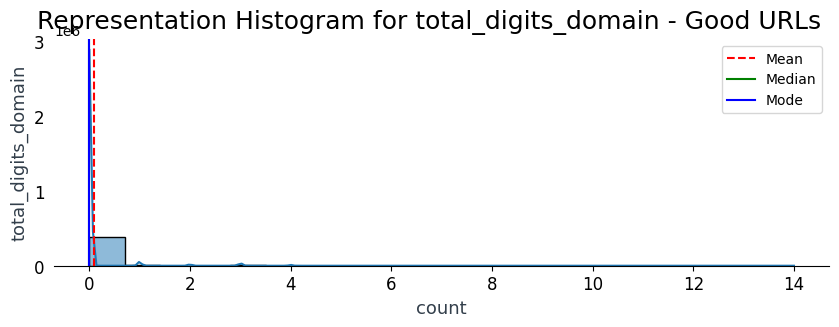

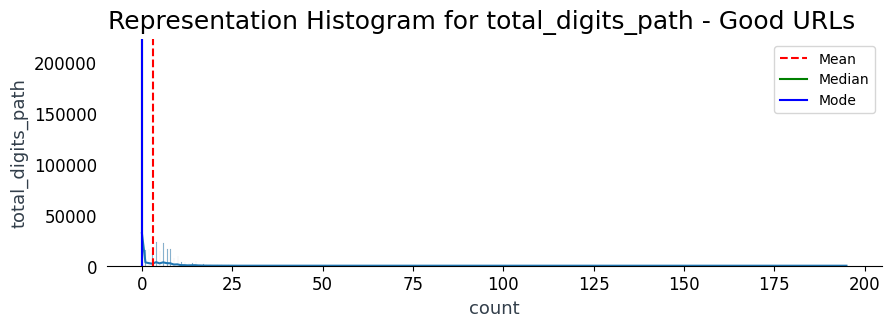

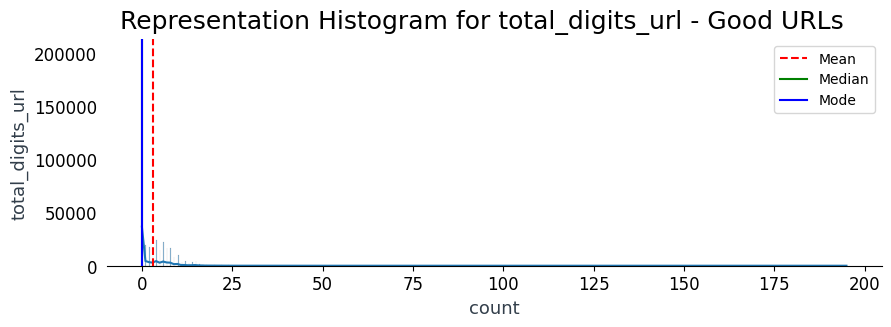

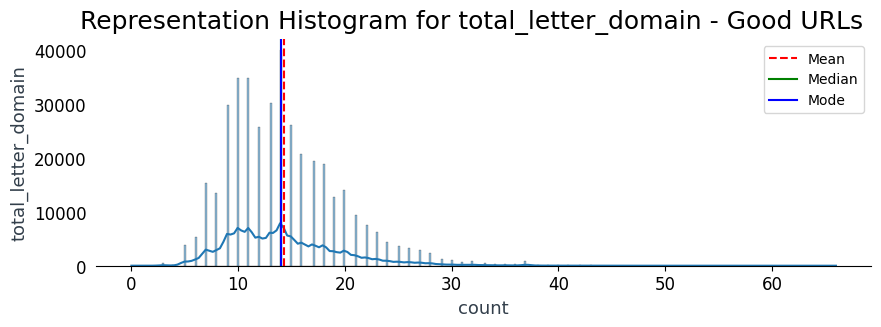

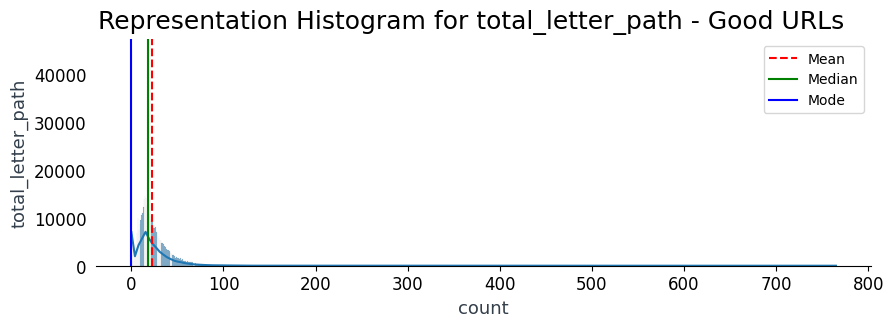

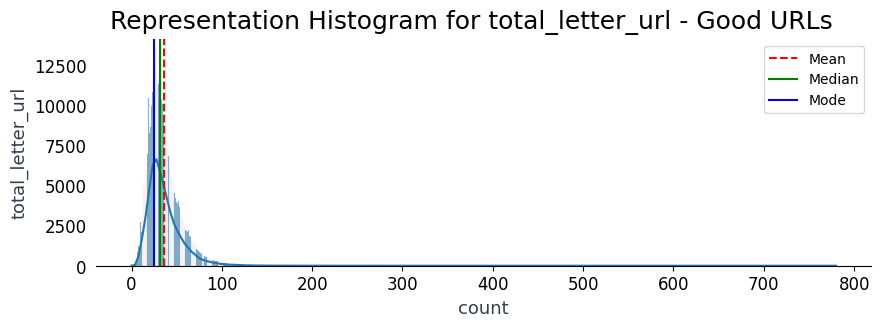

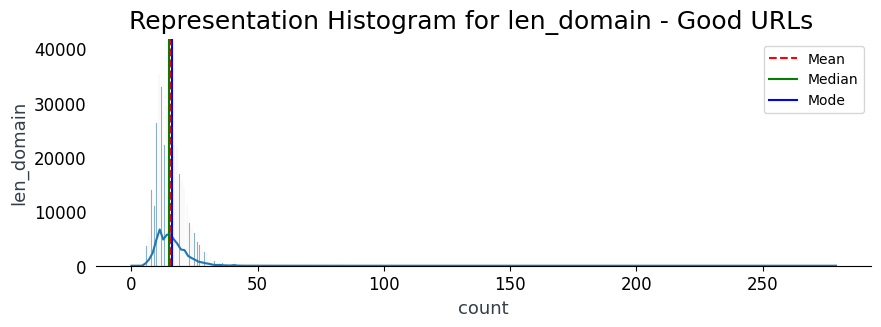

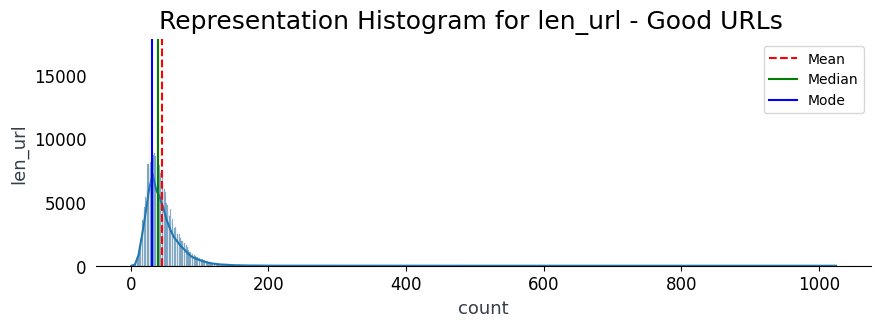

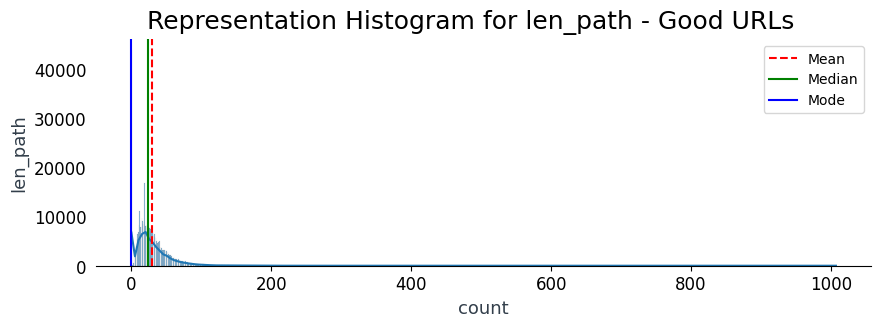

In [ ]:
get_histplot_central_tendency(data.query('Label == "good"'), features, "Good URLs")

In [ ]:
def dict_to_dataframe(dictionary: dict):
    pandas_to = {"name": [], "total": []}
    for name, value in dictionary.items():
        if len(name.replace(" ", "")) > 0:
            pandas_to["name"].append(name)
            pandas_to["total"].append(value)
    return pd.DataFrame(pandas_to).sort_values(by=['total'], ascending=False)

In [ ]:
total_suffix_good = {}
total_suffix_bad = {}
for current, target in zip(data["URL"], data["Label"]):
    #Accurately separates a URL's subdomain, domain, and public suffix:
    url_tldextract = tldextract.extract(current)
    suffix_tld = url_tldextract.suffix
    #counter for suffix:
    if target == "good":
        if suffix_tld not in total_suffix_good:
            total_suffix_good[suffix_tld] = 0
        total_suffix_good[suffix_tld] += 1
        
    if target == "bad":
        if suffix_tld not in total_suffix_bad:
            total_suffix_bad[suffix_tld] = 0
        total_suffix_bad[suffix_tld] += 1

In [ ]:
df_tld_top_bad = dict_to_dataframe(total_suffix_bad)
df_tld_top_good = dict_to_dataframe(total_suffix_good)

In [ ]:
#fun to plot bar:
def bar_plot_data(df: dict, subtitle: str, figsize=(5, 4), inverted_x=True):
    fig, ax1 = plt.subplots(figsize=figsize, dpi=100)
    
    for spline in ['top', 'right', 'left']:
        ax1.spines[spline].set_visible(False)

    sns.barplot(data=df, palette='cool', x="name", y="total")
    ax1.tick_params(axis='both', which='both', labelsize=12, bottom=True, left=False)
    ax1.set_xlabel(f'{"name"}', fontsize=13, color = '#333F4B')
    ax1.set_ylabel(f'{"count"}', fontsize=13, color = '#333F4B')
    
    if inverted_x:
        plt.xticks(rotation=90)
        
    plt.plot(color="white", lw=3)
    fig.suptitle(subtitle, fontsize=18)
    plt.show()

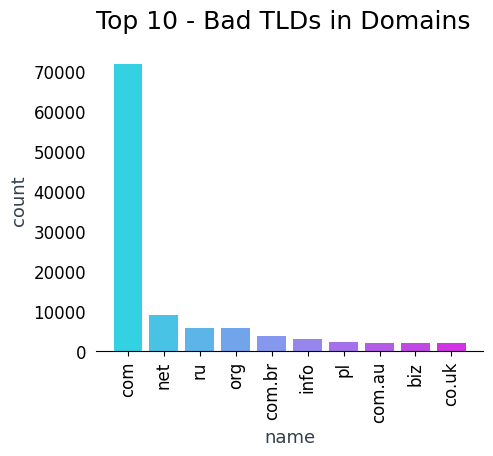

In [ ]:
bar_plot_data(df=df_tld_top_bad.head(10), subtitle="Top 10 - Bad TLDs in Domains")

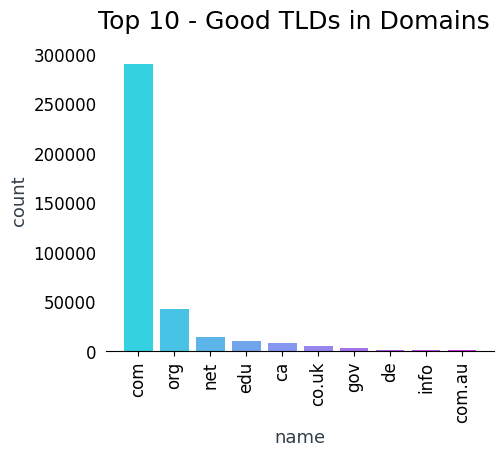

In [ ]:
bar_plot_data(df=df_tld_top_good.head(10), subtitle="Top 10 - Good TLDs in Domains")

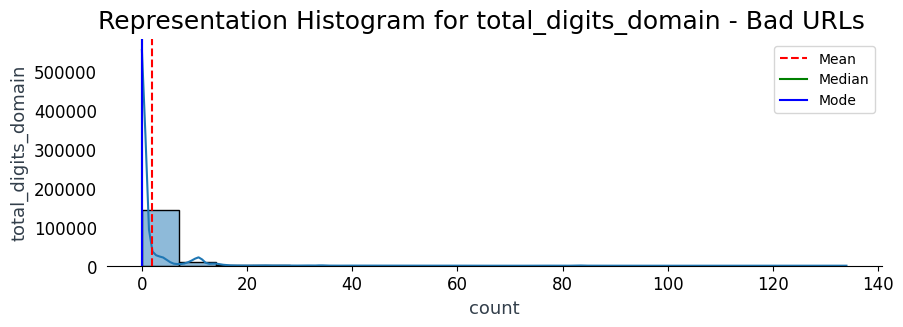

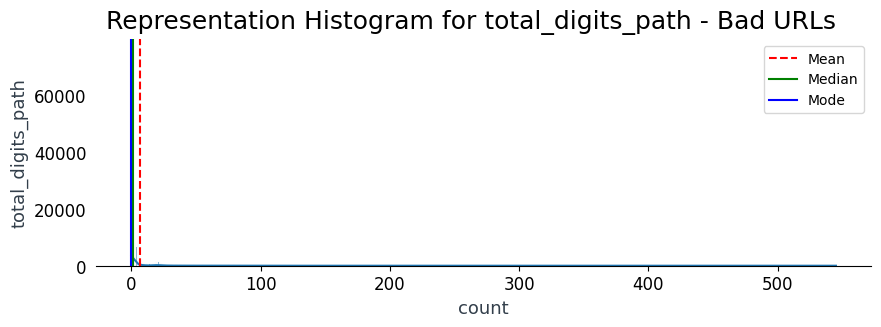

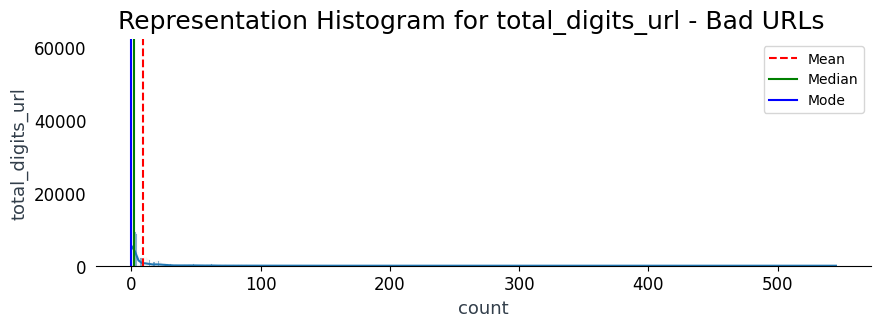

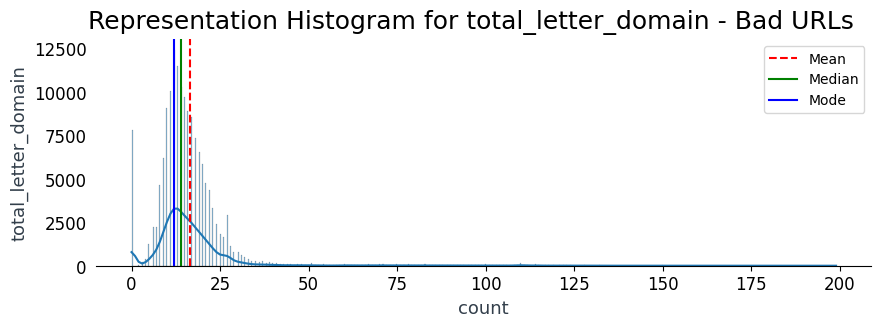

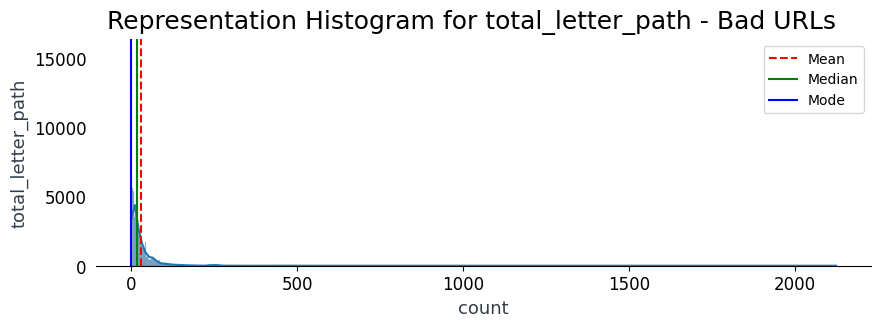

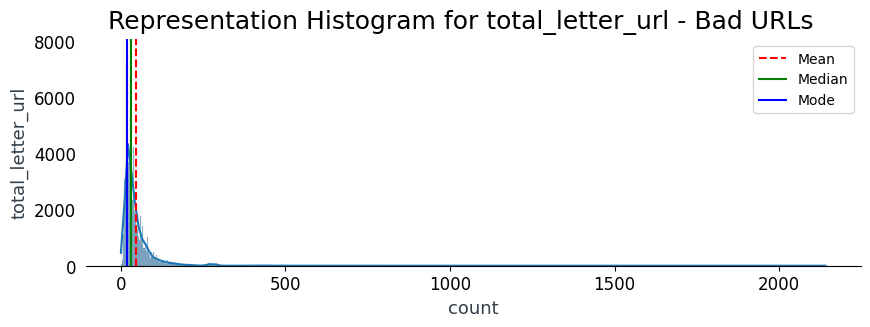

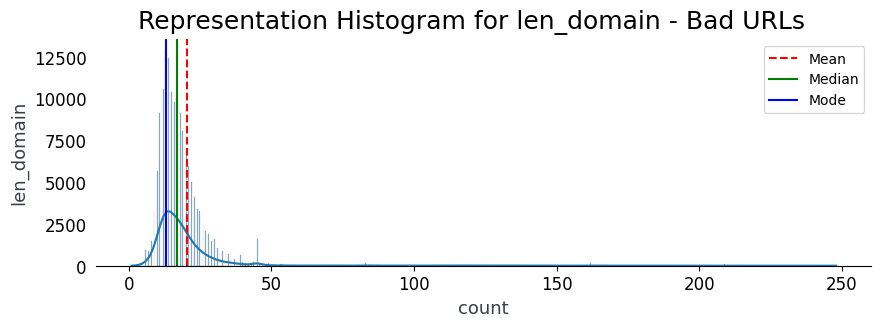

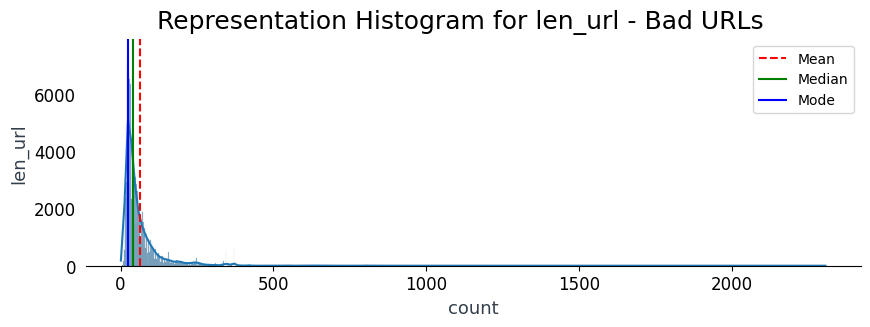

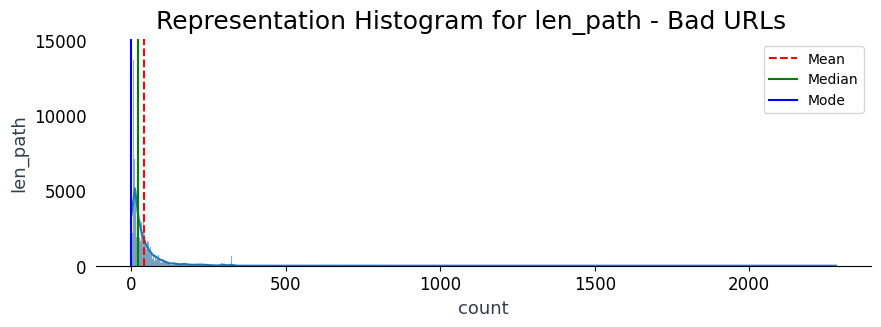

In [ ]:
get_histplot_central_tendency(data.query('Label == "bad"'), features, "Bad URLs")

In [ ]:
import nltk
nltk.download('punkt')
import tldextract
from urllib.parse import urlparse

from nltk.util import ngrams

def generate_url_ngrams(n: int, url: str):
    url_formated = ''
    for index, char in enumerate(url):
        if index % n == 0:
            url_formated += ' '
        url_formated += char

    ngram = ngrams(sequence=nltk.word_tokenize(url_formated), n=n)

    ngram_url = {}
    for grams in ngram:
        for gx in grams:
            ngram_url[gx] = 1
    return ngram_url


def get_fields_url(url: str):
    try:
        
        static_features = dict()

        url_tldextract = tldextract.extract(url)
        url_urlparse = urlparse(f"http://{url}")
        

        url_metadata = [
            {"name": "domain", "string": url_tldextract.domain},
            {"name": "subdomain", "string": url_tldextract.subdomain},
            {"name": "suffix", "string": url_tldextract.suffix},
            {"name": "path", "string": url_urlparse.path},
            {"name": "params", "string": url_urlparse.params},
            {"name": "query", "string": url_urlparse.query},
            {"name": "fragment", "string": url_urlparse.fragment}
        ]

        static_features.update(generate_url_ngrams(2, url_tldextract.domain))
        for current in url_metadata:
            static_features[f'len_{current["name"]}'] = len(current["string"])
            for char_ in list(map(str, "-@_?=&./,")):
                static_features[f'char{char_}-{current["name"]}'] = current["string"].count(char_)

            if "domain" == current["name"] or "path" == current["name"]:
                total_letter, total_number = 0, 0
                for char_ in list(map(str, "abcdefghijklmnopqrstuvwxyz")):
                    total_letter += current["string"].lower().count(char_)

                for char_ in list(map(str, "0123456789")):
                    total_number += current["string"].lower().count(char_)

                static_features[f'letter_len_{current["name"]}'] = total_letter
                static_features[f'number_len_{current["name"]}'] = total_number        
        
    except:
        return None         
    return static_features 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
output = []
features = []
for url, target in zip(data["URL"], data["Label"]):
    features_json = get_fields_url(url)
    if features_json:
        if target == "bad":
            target_int = 1
        if target == "good":
            target_int = 0    
        output.append(target_int)
        features.append(features_json)

In [ ]:
len(features), len(output)

(549312, 549312)

In [ ]:
pre_processor = DictVectorizer(sparse=True)
X = pre_processor.fit_transform(features)
X = csr_matrix(X)
X = X.tocsr()
y = np.array(output).astype(int)

In [ ]:
import scipy.sparse

In [ ]:
scipy.sparse.save_npz('data.npz', X)

In [ ]:
from numpy import savetxt

In [ ]:
savetxt('labels.csv', y, delimiter=',')

# modeling

In [1]:
from sklearn.model_selection import cross_validate

In [2]:
from numpy import loadtxt
y = loadtxt('/content/labels.csv', delimiter=',')

In [3]:
import scipy.sparse
X = scipy.sparse.load_npz('/content/data.npz')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, train_size=0.8)

In [6]:
def get_xgboost():
    return XGBClassifier(learning_rate=0.1, n_estimators=500,
                             objective='binary:logistic', seed=1,
                             silent=True, n_jobs=-1, max_depth=8,
                             colsample_bytree=1.0,
                             subsample=1.0)

In [8]:
model = get_xgboost()
model.fit(X_train, y_train)

In [ ]:
score = log_loss(y_test, model.predict_proba(X_test))
Y_pred = model.predict(X_test)
score_acc = accuracy_score(y_test, Y_pred)
score_pre = precision_score(y_test, Y_pred)
score_recall = recall_score(y_test, Y_pred)
score_f1 = f1_score(y_test, Y_pred)
cv_results = cross_validate(model, X, y, cv=3)
print(f"Log loss: {score}")
print(f"Score acc: {score_acc}")
print(f"score pre: {score_pre}")
print(f"score recall: {score_recall}")
print(f"score f1: {score_f1}")

Log loss: 0.1691895424282903
Score acc: 0.9348643310304652
score pre: 0.9256718528995757
score recall: 0.8381787909836066
score f1: 0.8797553434601425


In [10]:
cv_results = cross_validate(model, X, y, cv=3)

In [12]:
cv_results['test_score'].mean()

0.8560417394850286

In [13]:
from sklearn.ensemble import RandomForestClassifier
def get_RandomForest():
  return RandomForestClassifier(n_estimators=100, random_state=0)

In [ ]:
RF = get_RandomForest()
RF.fit(X_train, y_train)
score = log_loss(y_test, RF.predict_proba(X_test))
Y_pred = RF.predict(X_test)
score_acc = accuracy_score(y_test, Y_pred)
score_pre = precision_score(y_test, Y_pred)
score_recall = recall_score(y_test, Y_pred)
score_f1 = f1_score(y_test, Y_pred)

print(f"Log loss: {score}")
print(f"Score acc: {score_acc}")
print(f"score pre: {score_pre}")
print(f"score recall: {score_recall}")
print(f"score f1: {score_f1}")

Log loss: 0.1229286122428547
Score acc: 0.9660850331776849
score pre: 0.9681075561606535
score recall: 0.9107005635245902
score f1: 0.9385270243516134


In [14]:
RF = get_RandomForest()

In [15]:
cv_results = cross_validate(RF, X, y, cv=3)

In [17]:
cv_results['test_score'].mean()

0.8630286613072352

In [18]:
from sklearn import tree
def get_DecisionTree():
  return tree.DecisionTreeClassifier(criterion='gini',max_depth=15, random_state=0)

In [ ]:
DF = get_DecisionTree()
DF.fit(X_train, y_train)
score = log_loss(y_test, DF.predict_proba(X_test))
Y_pred = DF.predict(X_test)
score_acc = accuracy_score(y_test, Y_pred)
score_pre = precision_score(y_test, Y_pred)
score_recall = recall_score(y_test, Y_pred)
score_f1 = f1_score(y_test, Y_pred)

print(f"Log loss: {score}")
print(f"Score acc: {score_acc}")
print(f"score pre: {score_pre}")
print(f"score recall: {score_recall}")
print(f"score f1: {score_f1}")

Log loss: 0.3435835162563079
Score acc: 0.8973266704896098
score pre: 0.894183657341552
score recall: 0.7245773565573771
score f1: 0.8004952246197382


In [19]:
DF = get_DecisionTree()
cv_results = cross_validate(DF, X, y, cv=3)

In [20]:
cv_results['test_score'].mean()

0.8162119159967377

In [21]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 66 kB/s 


In [22]:
from catboost import CatBoostClassifier
def get_CatBoost():
    return CatBoostClassifier(
       iterations=1000, 
       learning_rate=0.1, 
       loss_function='CrossEntropy'
       )

In [ ]:
CB = get_CatBoost()
CB.fit(X_train, y_train)
score = log_loss(y_test, CB.predict_proba(X_test))
Y_pred = CB.predict(X_test)
score_acc = accuracy_score(y_test, Y_pred)
score_pre = precision_score(y_test, Y_pred)
score_recall = recall_score(y_test, Y_pred)
score_f1 = f1_score(y_test, Y_pred)

print(f"Log loss: {score}")
print(f"Score acc: {score_acc}")
print(f"score pre: {score_pre}")
print(f"score recall: {score_recall}")
print(f"score f1: {score_f1}")

0:	learn: 0.6363584	total: 1.03s	remaining: 17m 11s
1:	learn: 0.5922683	total: 2.03s	remaining: 16m 52s
2:	learn: 0.5612706	total: 2.99s	remaining: 16m 34s
3:	learn: 0.5353436	total: 4.09s	remaining: 16m 58s
4:	learn: 0.5119611	total: 5.05s	remaining: 16m 45s
5:	learn: 0.4938745	total: 5.86s	remaining: 16m 11s
6:	learn: 0.4788303	total: 6.82s	remaining: 16m 7s
7:	learn: 0.4671906	total: 7.9s	remaining: 16m 19s
8:	learn: 0.4581380	total: 8.86s	remaining: 16m 15s
9:	learn: 0.4438820	total: 10.1s	remaining: 16m 42s
10:	learn: 0.4366874	total: 11.2s	remaining: 16m 43s
11:	learn: 0.4268344	total: 12.5s	remaining: 17m 7s
12:	learn: 0.4204818	total: 13.6s	remaining: 17m 15s
13:	learn: 0.4146317	total: 14.7s	remaining: 17m 17s
14:	learn: 0.4032155	total: 16.4s	remaining: 17m 56s
15:	learn: 0.3933279	total: 18.3s	remaining: 18m 46s
16:	learn: 0.3862294	total: 19.7s	remaining: 18m 58s
17:	learn: 0.3825914	total: 20.9s	remaining: 18m 59s
18:	learn: 0.3776992	total: 22.4s	remaining: 19m 19s
19:	le

In [23]:
CB = get_CatBoost()
cv_results = cross_validate(CB, X, y, cv=3)

0:	learn: 0.6329484	total: 934ms	remaining: 15m 32s
1:	learn: 0.5858704	total: 1.77s	remaining: 14m 44s
2:	learn: 0.5484722	total: 2.77s	remaining: 15m 22s
3:	learn: 0.5188035	total: 3.42s	remaining: 14m 12s
4:	learn: 0.4955197	total: 4.41s	remaining: 14m 38s
5:	learn: 0.4757550	total: 5.38s	remaining: 14m 50s
6:	learn: 0.4594949	total: 6.33s	remaining: 14m 58s
7:	learn: 0.4451621	total: 7.19s	remaining: 14m 52s
8:	learn: 0.4307831	total: 8.21s	remaining: 15m 4s
9:	learn: 0.4205576	total: 9.09s	remaining: 15m
10:	learn: 0.4136278	total: 9.93s	remaining: 14m 53s
11:	learn: 0.4019947	total: 11s	remaining: 15m 8s
12:	learn: 0.3931685	total: 12s	remaining: 15m 8s
13:	learn: 0.3839507	total: 13.1s	remaining: 15m 22s
14:	learn: 0.3776122	total: 13.9s	remaining: 15m 16s
15:	learn: 0.3701041	total: 15s	remaining: 15m 22s
16:	learn: 0.3654983	total: 16.2s	remaining: 15m 37s
17:	learn: 0.3588132	total: 17.6s	remaining: 15m 57s
18:	learn: 0.3541258	total: 18.5s	remaining: 15m 56s
19:	learn: 0.350

In [24]:
cv_results['test_score'].mean()

0.8545325789351043